In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from IPython.display import clear_output

class WaterQualityOptimizer:
    def __init__(self, filepath):
        self.filepath = filepath
        self.X, self.y = self.load_data()
        self.attributes = self.X.columns.tolist()
        self.best_solution = None
        self.best_score = -np.inf
        self.iteration_stats = []
        
        # Configuration de la visualisation
        plt.ion()
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    def load_data(self):
        """Charge les données et vérifie les NaN"""
        data = pd.read_csv(self.filepath)
        print(f"Données chargées. NaN trouvés: {data.isna().sum().sum()}")
        X = data.drop('Potability', axis=1)
        y = data['Potability']
        return X, y
    
    def impute_data(self, strategy_params):
        """Imputation des données avec stratégie donnée"""
        imputer = SimpleImputer(
            strategy=strategy_params['strategy'],
            fill_value=strategy_params.get('fill_value')
        )
        X_imputed = pd.DataFrame(imputer.fit_transform(self.X), columns=self.attributes)
        scaler = StandardScaler()
        return pd.DataFrame(scaler.fit_transform(X_imputed), columns=self.attributes)
    
    def evaluate_solution(self, imputation_params, feature_subset):
        """Évaluation avec KNN"""
        try:
            X_imputed = self.impute_data(imputation_params)
            if len(feature_subset) == 0:
                return 0.0
                
            X_subset = X_imputed.iloc[:, feature_subset]
            X_train, X_test, y_train, y_test = train_test_split(
                X_subset, self.y, test_size=0.3, random_state=42)
            
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train, y_train)
            return accuracy_score(y_test, knn.predict(X_test))
        except Exception as e:
            print(f"Erreur d'évaluation: {str(e)}")
            return 0.0
    
    def SCA_generate_solutions(self, num_solutions):
        """Génère des stratégies d'imputation"""
        strategies = ['mean', 'median', 'most_frequent', 'constant']
        return [{
            'strategy': np.random.choice(strategies),
            'fill_value': np.random.uniform(self.X.min().min(), self.X.max().max()) 
            if np.random.rand() > 0.5 else None
        } for _ in range(num_solutions)]
    
    def GWO_feature_selection(self, X_imputed, num_wolves, max_iter):
        """Sélection d'attributs avec GWO (version corrigée)"""
        num_features = X_imputed.shape[1]
        wolves = np.random.rand(num_wolves, num_features) > 0.5
        
        alpha, beta, delta = wolves[:3].copy()
        alpha_fitness = beta_fitness = delta_fitness = -np.inf
        
        for it in range(max_iter):
            a = 2 - it * (2 / max_iter)  # Paramètre de contrôle
            
            # Évaluation des loups
            for i in range(num_wolves):
                selected = np.where(wolves[i])[0]
                fitness = self.evaluate_solution({'strategy': 'mean'}, selected)
                
                # Mise à jour des leaders
                if fitness > alpha_fitness:
                    alpha, beta, delta = wolves[i].copy(), alpha.copy(), beta.copy()
                    alpha_fitness, beta_fitness, delta_fitness = fitness, alpha_fitness, beta_fitness
                elif fitness > beta_fitness:
                    beta, delta = wolves[i].copy(), beta.copy()
                    beta_fitness, delta_fitness = fitness, beta_fitness
                elif fitness > delta_fitness:
                    delta = wolves[i].copy()
                    delta_fitness = fitness
            
            # Mise à jour des positions
            for i in range(num_wolves):
                for j in range(num_features):
                    # Calcul des composantes
                    A_alpha = a * (2 * np.random.rand() - 1)
                    C_alpha = 2 * np.random.rand()
                    D_alpha = abs(C_alpha * alpha[j] - wolves[i,j])
                    X1 = alpha[j] - A_alpha * D_alpha
                    
                    A_beta = a * (2 * np.random.rand() - 1)
                    C_beta = 2 * np.random.rand()
                    D_beta = abs(C_beta * beta[j] - wolves[i,j])
                    X2 = beta[j] - A_beta * D_beta
                    
                    A_delta = a * (2 * np.random.rand() - 1)
                    C_delta = 2 * np.random.rand()
                    D_delta = abs(C_delta * delta[j] - wolves[i,j])
                    X3 = delta[j] - A_delta * D_delta
                    
                    # Mise à jour de la position
                    wolves[i,j] = np.clip((X1 + X2 + X3) / 3, 0, 1)
                
                # Conversion en binaire
                wolves[i] = wolves[i] > 0.5
        
        best_subset = np.where(alpha)[0]
        return best_subset, alpha_fitness
    
    def update_visualization(self):
        """Met à jour les graphiques en temps réel"""
        clear_output(wait=True)
        
        # Données pour les graphiques
        iterations = [stat['iteration'] for stat in self.iteration_stats]
        accuracies = [stat['accuracy'] for stat in self.iteration_stats]
        best_accuracies = [max(accuracies[:i+1]) for i in range(len(accuracies))]
        
        # Graphique 1: Progression de l'accuracy
        self.ax1.clear()
        self.ax1.plot(iterations, accuracies, 'b-', label='Accuracy actuelle')
        self.ax1.plot(iterations, best_accuracies, 'r--', label='Meilleure accuracy')
        self.ax1.set_title('Progression de la précision')
        self.ax1.set_xlabel('Itération')
        self.ax1.set_ylabel('Accuracy')
        self.ax1.legend()
        self.ax1.grid(True)
        
        # Graphique 2: Stratégies d'imputation
        strategies = [stat['imputation_strategy'] for stat in self.iteration_stats]
        unique_strategies = list(set(strategies))
        strategy_counts = [strategies.count(s) for s in unique_strategies]
        
        self.ax2.clear()
        self.ax2.bar(unique_strategies, strategy_counts)
        self.ax2.set_title('Utilisation des stratégies d\'imputation')
        self.ax2.set_xlabel('Stratégie')
        self.ax2.set_ylabel('Nombre d\'utilisations')
        
        plt.tight_layout()
        plt.show()
    
    def optimize(self, num_iterations=10, num_sca_solutions=3, num_gwo_wolves=8, gwo_iterations=15):
        """Processus d'optimisation principal avec visualisation"""
        for iteration in range(num_iterations):
            print(f"\n=== ITÉRATION {iteration+1}/{num_iterations} ===")
            
            # Génération des solutions d'imputation
            imputation_solutions = self.SCA_generate_solutions(num_sca_solutions)
            
            for sol_idx, imp_sol in enumerate(imputation_solutions):
                # Sélection d'attributs avec GWO
                X_imputed = self.impute_data(imp_sol)
                feature_subset, gwo_score = self.GWO_feature_selection(
                    X_imputed, num_gwo_wolves, gwo_iterations)
                
                # Évaluation complète
                final_score = self.evaluate_solution(imp_sol, feature_subset)
                
                # Mise à jour de la meilleure solution
                if final_score > self.best_score:
                    self.best_score = final_score
                    self.best_solution = {
                        'imputation': imp_sol,
                        'features': feature_subset,
                        'score': final_score
                    }
                
                # Enregistrement des statistiques
                self.iteration_stats.append({
                    'iteration': len(self.iteration_stats)+1,
                    'accuracy': final_score,
                    'imputation_strategy': imp_sol['strategy'],
                    'num_features': len(feature_subset)
                })
                
                # Affichage en temps réel
                print(f"Solution {sol_idx+1}:")
                print(f"  Stratégie: {imp_sol['strategy']}")
                print(f"  Attributs: {len(feature_subset)}/{X_imputed.shape[1]}")
                print(f"  Accuracy: {final_score:.4f}")
                print(f"  Meilleure accuracy globale: {self.best_score:.4f}")
                
                # Mise à jour de la visualisation
                self.update_visualization()
        
        # Résumé final
        print("\n=== OPTIMISATION TERMINÉE ===")
        print(f"Meilleure solution trouvée:")
        print(f"  Stratégie d'imputation: {self.best_solution['imputation']}")
        print(f"  Attributs sélectionnés: {len(self.best_solution['features'])}")
        print(f"  Accuracy: {self.best_score:.4f}")
        
        return self.best_solution

# Exemple d'utilisation
if __name__ == "__main__":
    optimizer = WaterQualityOptimizer('water_potability.csv')
    best_solution = optimizer.optimize(
        num_iterations=5,
        num_sca_solutions=3,
        num_gwo_wolves=8,
        gwo_iterations=10
    )

<Figure size 640x480 with 0 Axes>


=== OPTIMISATION TERMINÉE ===
Meilleure solution trouvée:
  Stratégie d'imputation: {'strategy': 'mean', 'fill_value': None}
  Attributs sélectionnés: 8
  Accuracy: 0.6765


Début de l'optimisation...


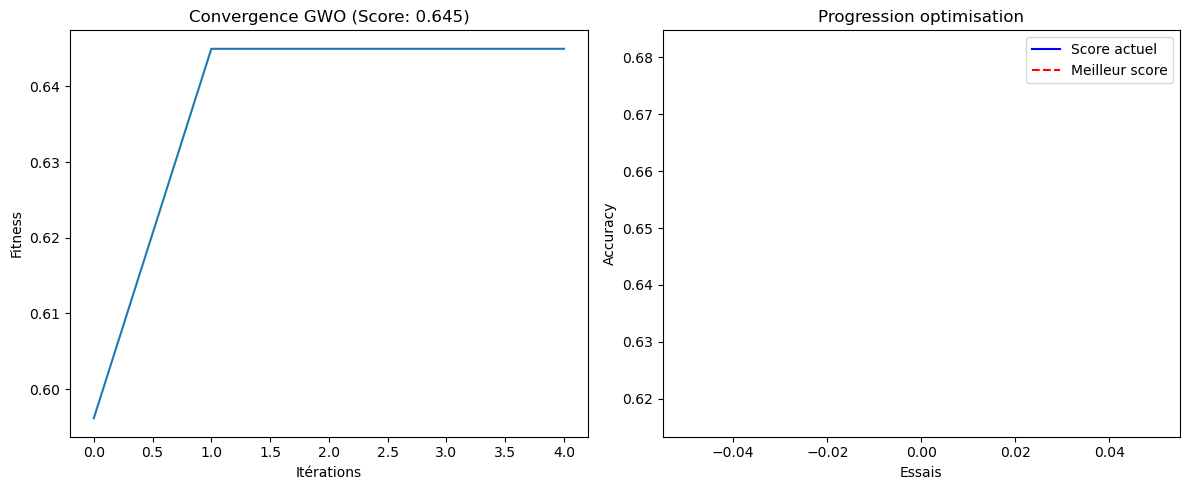

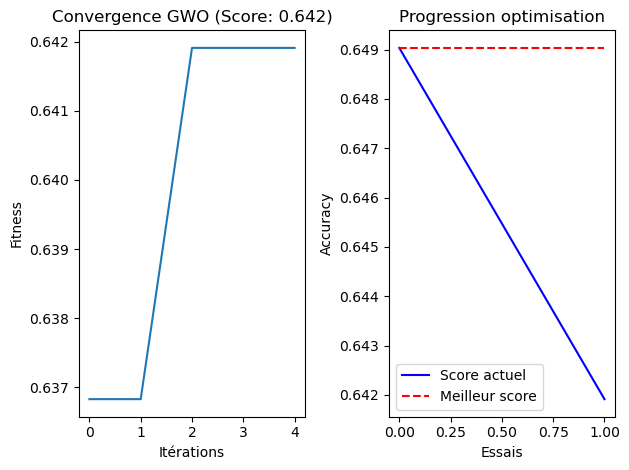

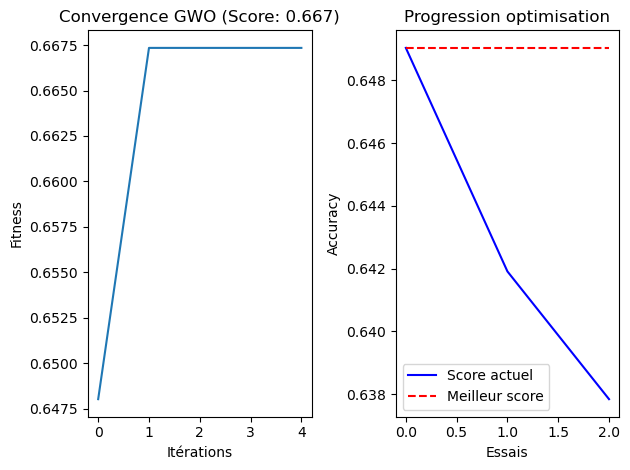

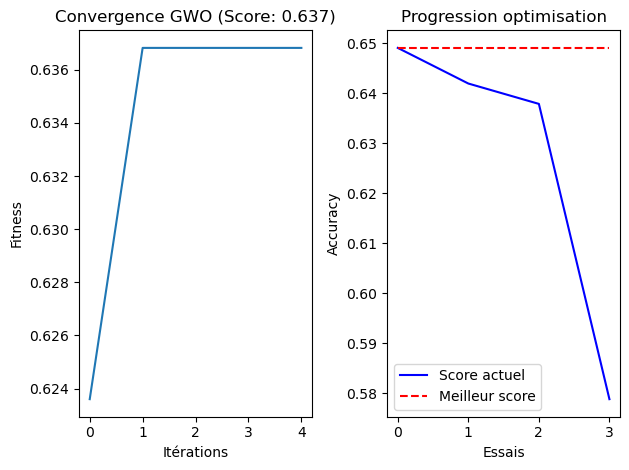

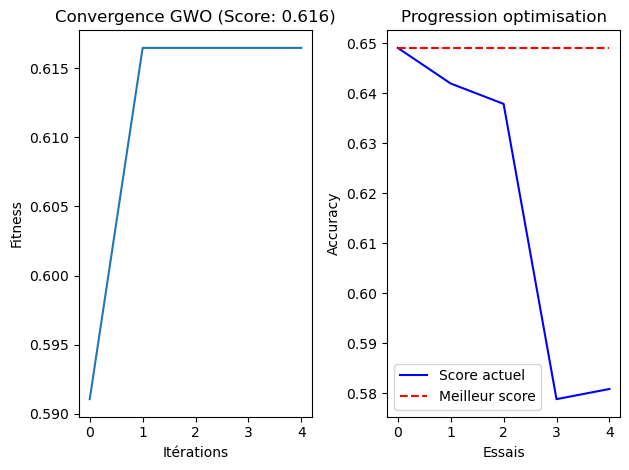

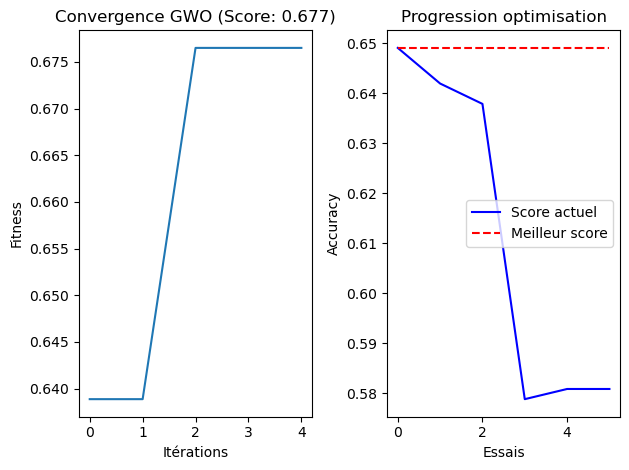

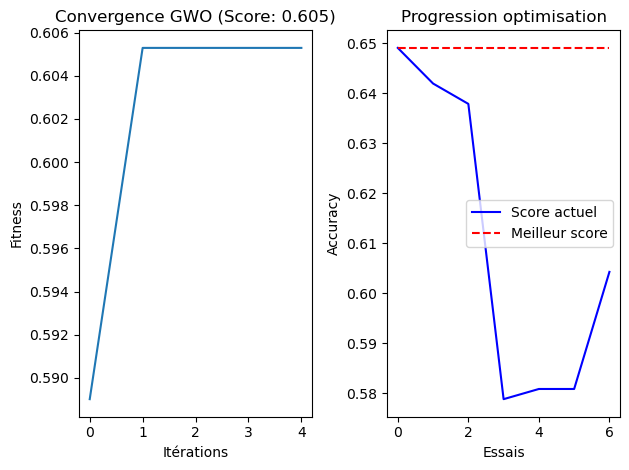

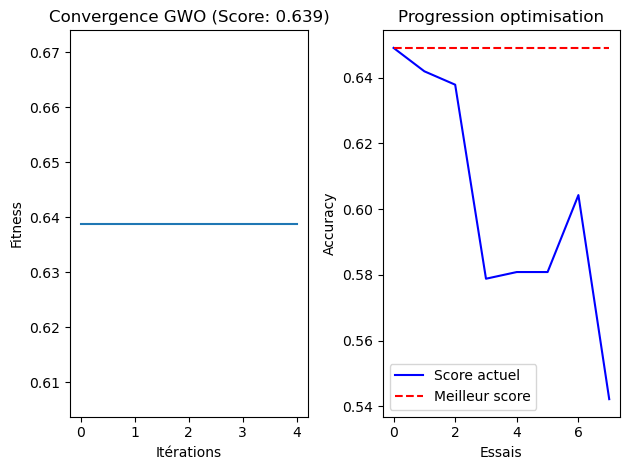

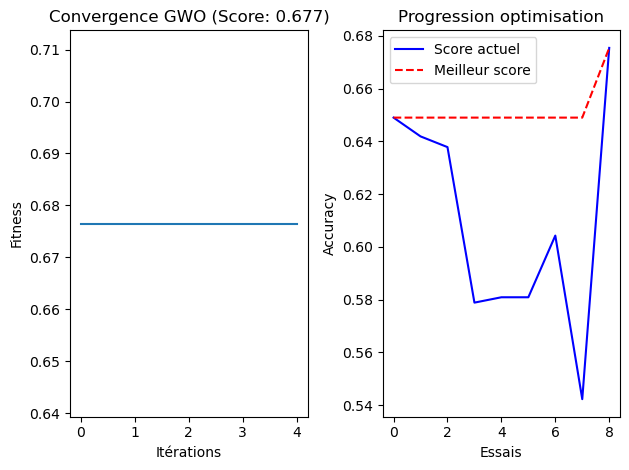

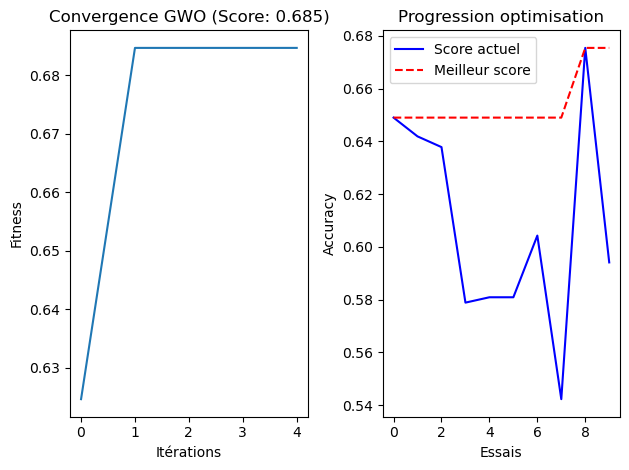

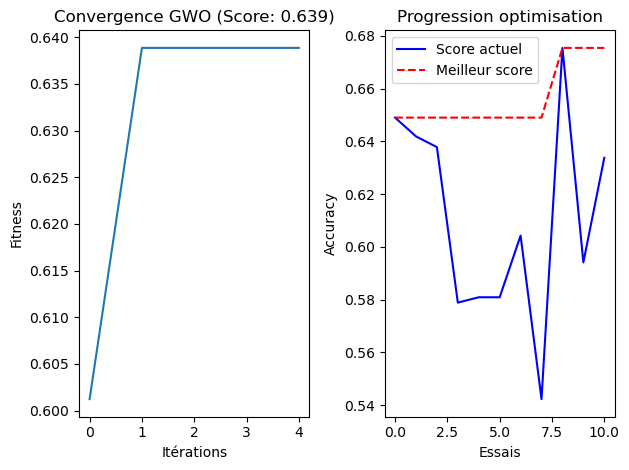

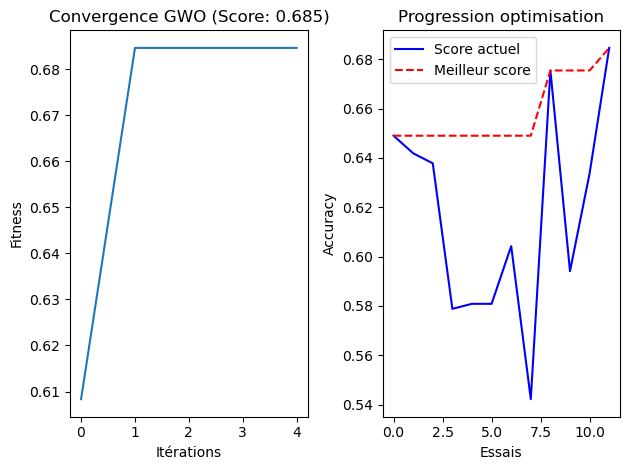

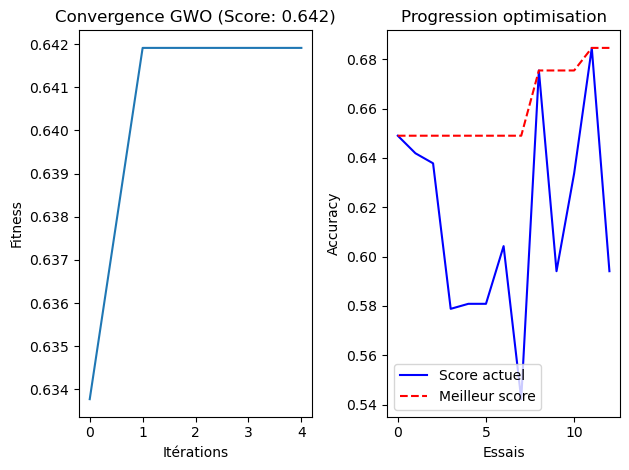

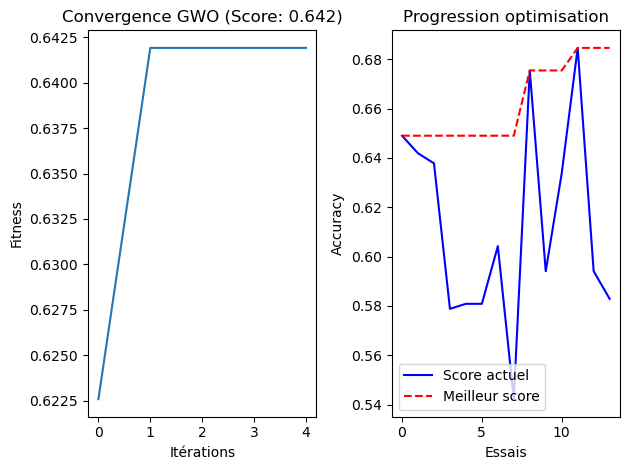

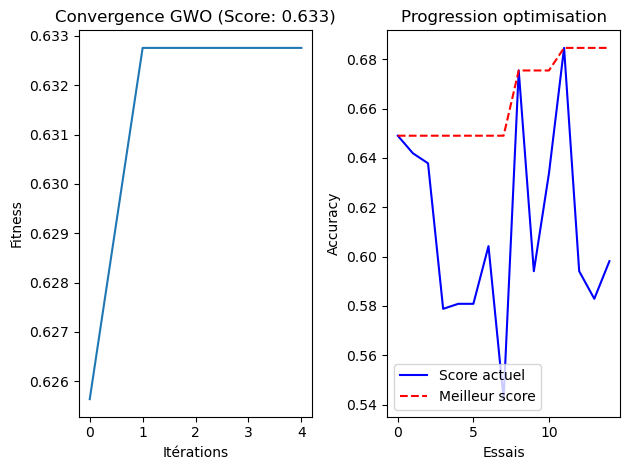

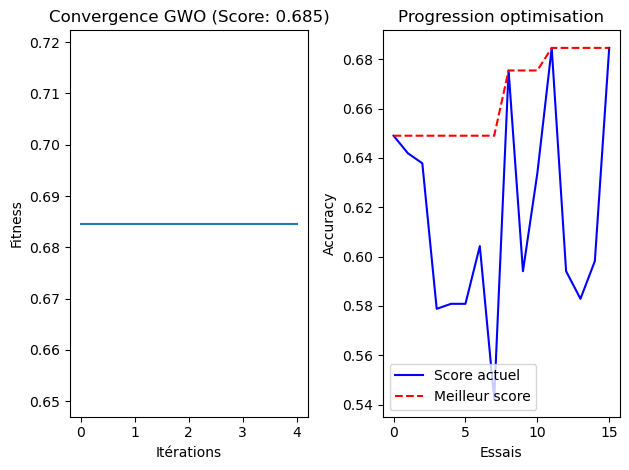

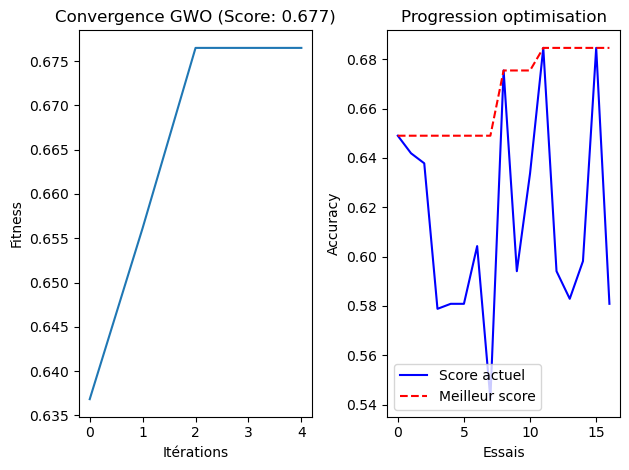

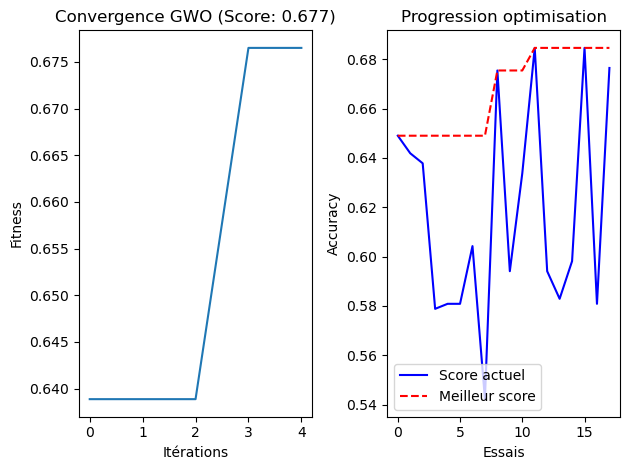

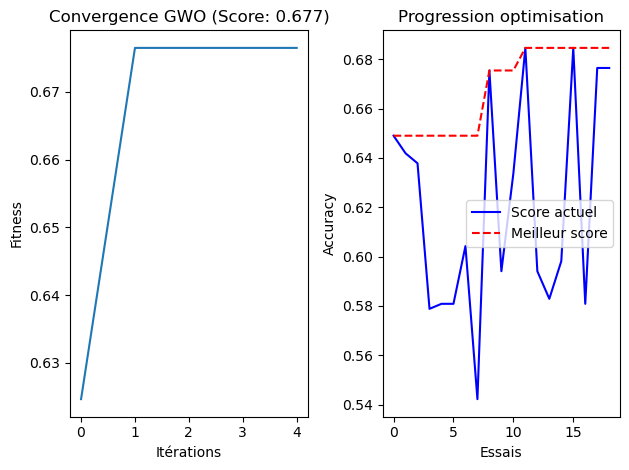

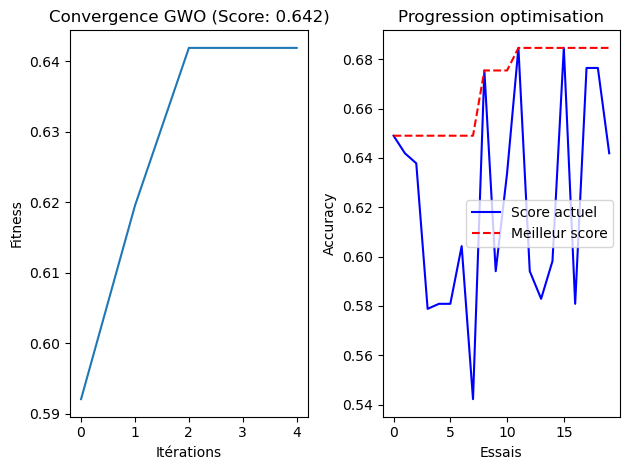

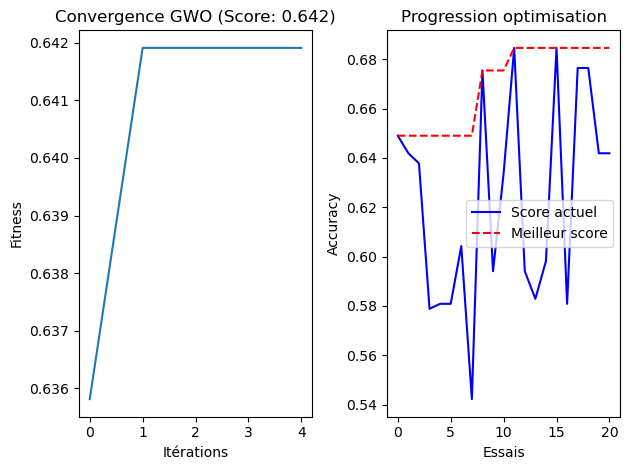

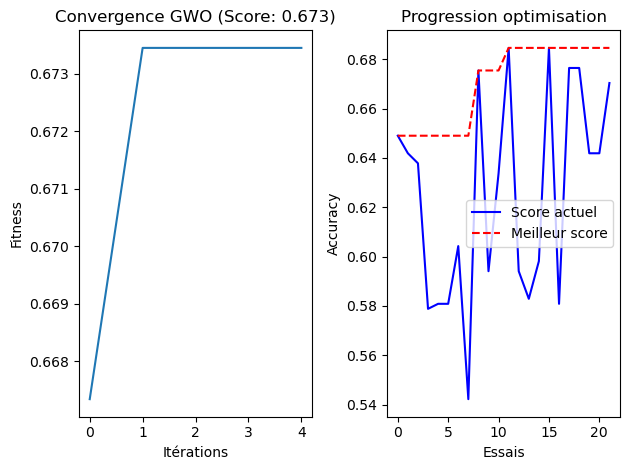

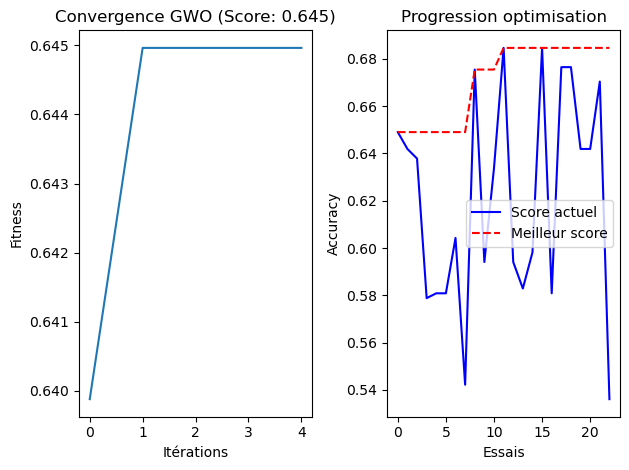

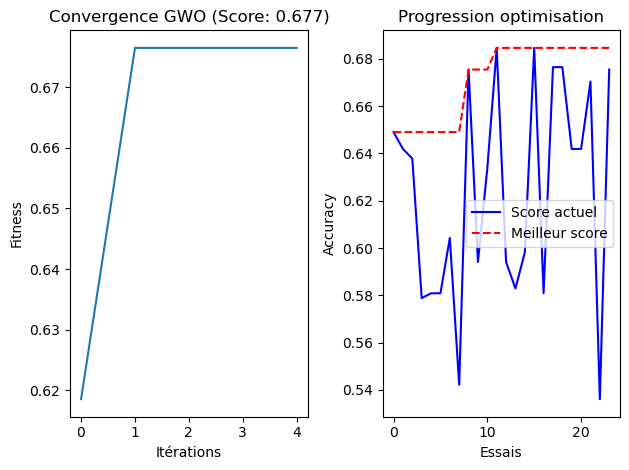

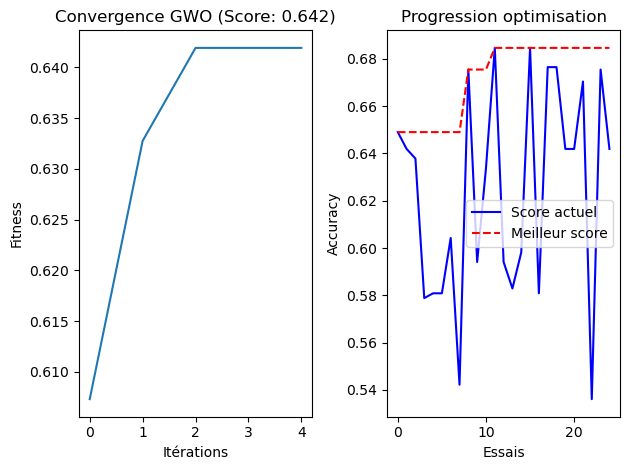

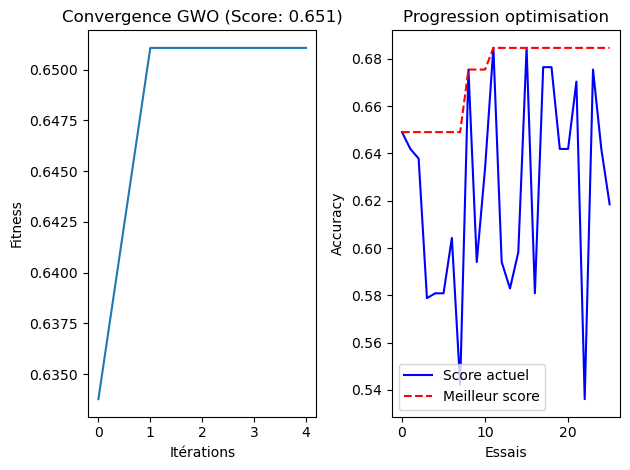

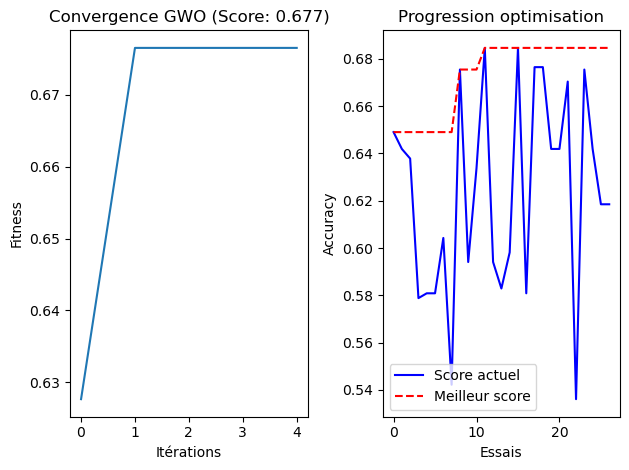

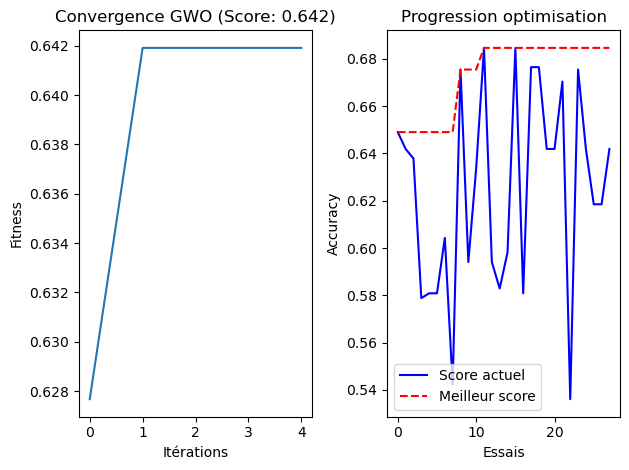

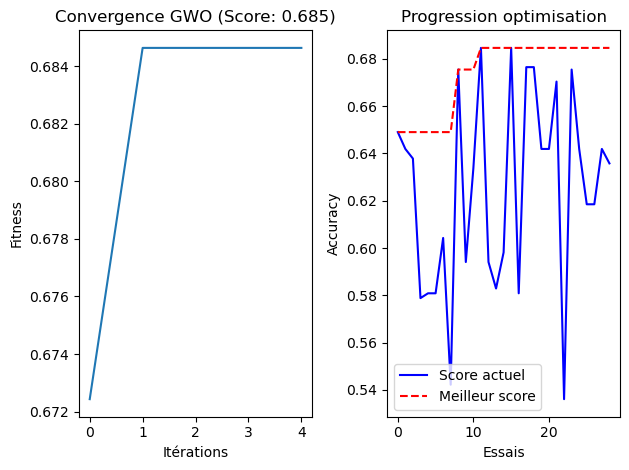

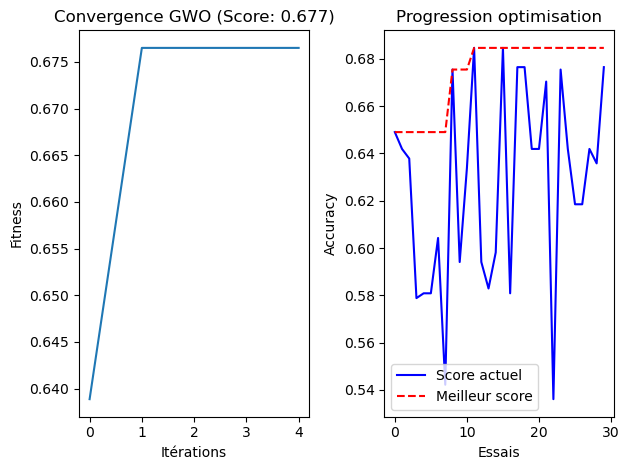

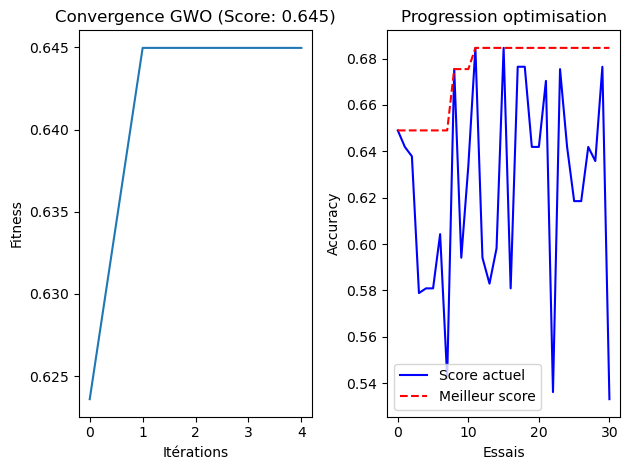

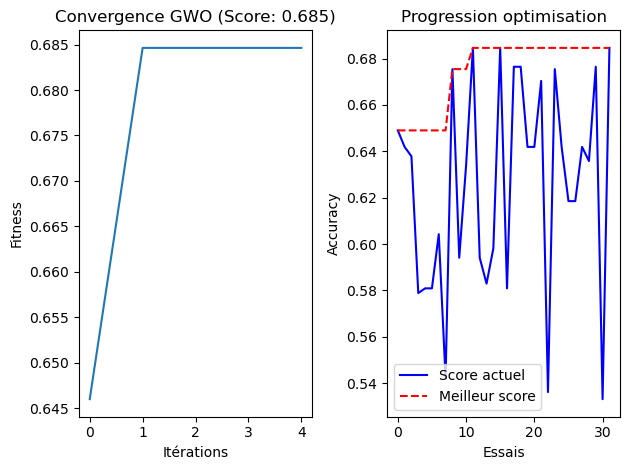

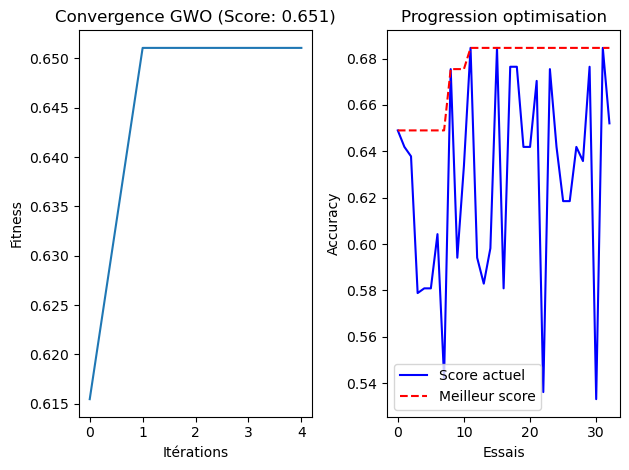

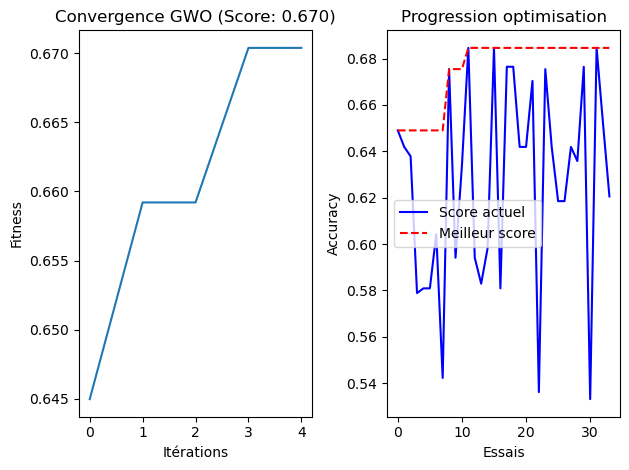

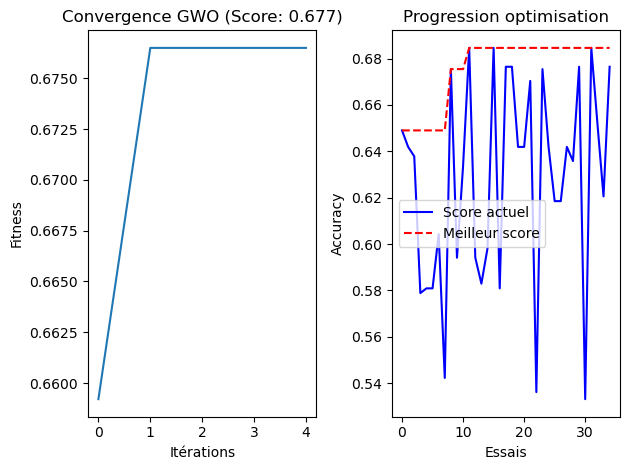

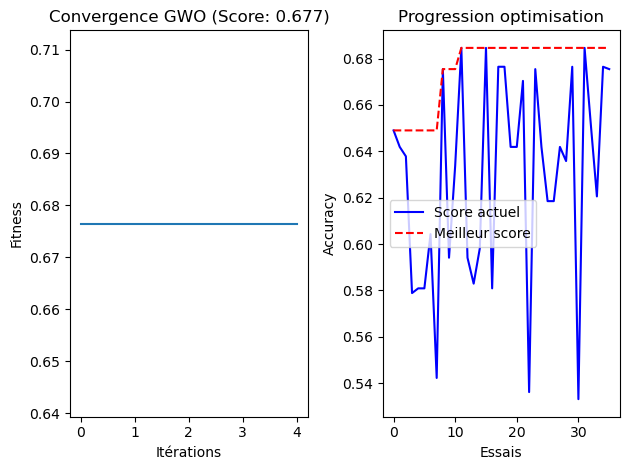


Meilleure solution trouvée:
Stratégie d'imputation: {'strategy': 'mean', 'fill_value': None}
Attributs sélectionnés: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Turbidity']
Accuracy: 0.6846

Table finale imputée avec les meilleurs attributs:


C:\Users\MSI\AppData\Local\Temp\ipykernel_8036\1128699518.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features['Potability'] = self.y.values


,ph,Hardness,Solids,Chloramines,Sulfate,Turbidity,Potability
0,-6.043133e-16,0.259195,-0.139471,0.112415,9.613574e-01,-1.286298,0
1,-2.289339e+00,-2.036414,-0.385987,-0.307694,3.145987e-15,0.684218,0
2,6.928678e-01,0.847665,-0.240047,1.360594,3.145987e-15,-1.167365,0
3,8.409504e-01,0.547651,0.000493,0.592008,6.395190e-01,0.848412,0
4,1.368569e+00,-0.464429,-0.460249,-0.363698,-6.541765e-01,0.138786,0



Résultats détaillés:


,iteration,strategy,features,score
0,0,median,"[0, 1, 2, 4, 7, 8]",0.649034
1,0,mean,"[0, 1, 2, 3, 4, 5, 6, 7]",0.641913
2,0,most_frequent,"[0, 1, 3, 4, 5]",0.637843
3,0,constant,"[0, 1, 2, 3, 4, 5, 6, 8]",0.578840
4,0,constant,"[0, 1, 2, 3, 5]",0.580875
5,0,constant,"[0, 1, 2, 3, 4, 5, 7, 8]",0.580875
6,0,median,"[1, 3, 4, 7]",0.604273
7,0,constant,"[0, 2, 3, 4, 5, 7, 8]",0.542218
8,0,median,"[0, 1, 2, 3, 4, 5, 7, 8]",0.675483
9,1,constant,"[0, 1, 2, 3, 4, 8]",0.594100


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from IPython.display import display

class WaterQualityOptimizer:
    def __init__(self, filepath):
        self.filepath = filepath
        self.raw_data = pd.read_csv(filepath)
        self.X = self.raw_data.drop('Potability', axis=1)
        self.y = self.raw_data['Potability']
        self.attributes = self.X.columns.tolist()
        self.best_solution = None
        self.best_score = -np.inf
        self.results = []
        
    def impute_data(self, strategy_params):
        """Imputation des données selon la stratégie"""
        imputer = SimpleImputer(
            strategy=strategy_params['strategy'],
            fill_value=strategy_params.get('fill_value')
        )
        X_imputed = pd.DataFrame(imputer.fit_transform(self.X), 
                               columns=self.attributes)
        scaler = StandardScaler()
        return pd.DataFrame(scaler.fit_transform(X_imputed), 
                          columns=self.attributes)
    
    def evaluate_features(self, imputation_params, feature_subset):
        """Évaluation avec KNN"""
        try:
            X_imputed = self.impute_data(imputation_params)
            if len(feature_subset) == 0:
                return 0.0
                
            X_subset = X_imputed.iloc[:, feature_subset]
            X_train, X_test, y_train, y_test = train_test_split(
                X_subset, self.y, test_size=0.3, random_state=42)
            
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train, y_train)
            return accuracy_score(y_test, knn.predict(X_test))
        except:
            return 0.0
    
    def SCA_generate_solutions(self, num_solutions):
        """Génère des solutions d'imputation avec SCA"""
        strategies = ['mean', 'median', 'most_frequent', 'constant']
        solutions = []
        for _ in range(num_solutions):
            strategy = np.random.choice(strategies)
            fill_value = np.random.uniform(self.X.min().min(), self.X.max().max()) if strategy == 'constant' else None
            solutions.append({'strategy': strategy, 'fill_value': fill_value})
        return solutions
    
    def GWO_feature_selection(self, X_imputed, num_wolves=10, max_iter=20):
        """Sélection d'attributs avec GWO"""
        num_features = X_imputed.shape[1]
        wolves = np.random.rand(num_wolves, num_features) > 0.5
        
        alpha = wolves[0].copy()
        alpha_fitness = -np.inf
        beta = wolves[1].copy()
        beta_fitness = -np.inf
        delta = wolves[2].copy()
        delta_fitness = -np.inf
        
        fitness_history = []
        
        for it in range(max_iter):
            a = 2 - it * (2 / max_iter)
            
            for i in range(num_wolves):
                selected = np.where(wolves[i])[0]
                fitness = self.evaluate_features({'strategy': 'mean'}, selected)
                
                if fitness > alpha_fitness:
                    delta = beta.copy()
                    delta_fitness = beta_fitness
                    beta = alpha.copy()
                    beta_fitness = alpha_fitness
                    alpha = wolves[i].copy()
                    alpha_fitness = fitness
                elif fitness > beta_fitness:
                    delta = beta.copy()
                    delta_fitness = beta_fitness
                    beta = wolves[i].copy()
                    beta_fitness = fitness
                elif fitness > delta_fitness:
                    delta = wolves[i].copy()
                    delta_fitness = fitness
            
            for i in range(num_wolves):
                for j in range(num_features):
                    # Mise à jour position
                    A1 = 2 * a * np.random.rand() - a
                    C1 = 2 * np.random.rand()
                    D_alpha = abs(C1 * alpha[j] - wolves[i,j])
                    X1 = alpha[j] - A1 * D_alpha
                    
                    A2 = 2 * a * np.random.rand() - a
                    C2 = 2 * np.random.rand()
                    D_beta = abs(C2 * beta[j] - wolves[i,j])
                    X2 = beta[j] - A2 * D_beta
                    
                    A3 = 2 * a * np.random.rand() - a
                    C3 = 2 * np.random.rand()
                    D_delta = abs(C3 * delta[j] - wolves[i,j])
                    X3 = delta[j] - A3 * D_delta
                    
                    wolves[i,j] = np.clip((X1 + X2 + X3) / 3, 0, 1)
                
                # Conversion binaire
                wolves[i] = wolves[i] > 0.5
            
            fitness_history.append(alpha_fitness)
        
        best_subset = np.where(alpha)[0]
        return best_subset, alpha_fitness, fitness_history
    
    def optimize(self, num_iterations=5, num_sca_solutions=3, num_gwo_wolves=8, gwo_iterations=15):
        """Processus d'optimisation complet"""
        plt.figure(figsize=(12, 5))
        
        for iteration in range(num_iterations):
            imputation_solutions = self.SCA_generate_solutions(num_sca_solutions)
            
            for imp_sol in imputation_solutions:
                X_imputed = self.impute_data(imp_sol)
                feature_subset, score, history = self.GWO_feature_selection(
                    X_imputed, num_gwo_wolves, gwo_iterations)
                
                final_score = self.evaluate_features(imp_sol, feature_subset)
                
                if final_score > self.best_score:
                    self.best_solution = {
                        'imputation': imp_sol,
                        'features': feature_subset,
                        'score': final_score,
                        'imputed_data': X_imputed
                    }
                    self.best_score = final_score
                
                self.results.append({
                    'iteration': iteration,
                    'strategy': imp_sol['strategy'],
                    'features': feature_subset,
                    'score': final_score
                })
                
                # Affichage dynamique
                plt.clf()
                
                # Graphique convergence GWO
                plt.subplot(1, 2, 1)
                plt.plot(history)
                plt.title(f'Convergence GWO (Score: {score:.3f})')
                plt.xlabel('Itérations')
                plt.ylabel('Fitness')
                
                # Graphique scores globaux
                plt.subplot(1, 2, 2)
                scores = [r['score'] for r in self.results]
                plt.plot(scores, 'b-', label='Score actuel')
                plt.plot([max(scores[:i+1]) for i in range(len(scores))], 'r--', label='Meilleur score')
                plt.title('Progression optimisation')
                plt.xlabel('Essais')
                plt.ylabel('Accuracy')
                plt.legend()
                
                plt.tight_layout()
                plt.pause(0.1)
        
        plt.show()
        return self.best_solution
    
    def get_final_imputed_table(self):
        """Retourne la table finale imputée avec les meilleurs paramètres"""
        if not self.best_solution:
            raise ValueError("Vous devez d'abord exécuter optimize()")
            
        imputed_data = self.impute_data(self.best_solution['imputation'])
        selected_features = imputed_data.iloc[:, self.best_solution['features']]
        selected_features['Potability'] = self.y.values
        
        return selected_features

# Utilisation
if __name__ == "__main__":
    # Initialisation
    optimizer = WaterQualityOptimizer('water_potability.csv')
    
    # Optimisation
    print("Début de l'optimisation...")
    best_solution = optimizer.optimize(
        num_iterations=4,
        num_sca_solutions=9,
        num_gwo_wolves=8,
        gwo_iterations=5
    )
    
    # Résultats
    print("\nMeilleure solution trouvée:")
    print(f"Stratégie d'imputation: {best_solution['imputation']}")
    print(f"Attributs sélectionnés: {[optimizer.attributes[i] for i in best_solution['features']]}")
    print(f"Accuracy: {best_solution['score']:.4f}")
    
    # Table finale imputée
    final_table = optimizer.get_final_imputed_table()
    print("\nTable finale imputée avec les meilleurs attributs:")
    display(final_table.head())
    
    # Affichage des résultats
    results_df = pd.DataFrame(optimizer.results)
    print("\nRésultats détaillés:")
    display(results_df)